# Data Collection Pipeline 

## Two-Phase Approach:

### Phase 1: Build Cost Pool
- Generate random cost parameters
- Optimize each with ODL API
- Store (costs, features) pairs
- Can skip if you already have cost_pool.json

### Phase 2: Match Preferences (New!)
- Generate random preferences
- Get **top 30 solutions** from pool (closest to ideal)
- Use **Pareto evaluation** to select best
- Save training samples



## 1. Imports

In [1]:
import json
import time
import requests
import numpy as np
import pandas as pd
from datetime import datetime
from pathlib import Path
import copy
from typing import List, Dict
import os

print("✓ Imports successful")

✓ Imports successful


## 2. Configuration

**⚠️ UPDATE THESE VALUES:**

In [2]:
# API Configuration



# Model file (use relaxed version without skill requirements)
MODEL_PATH = "../test_model_fully_relaxed.json"  # ← CHANGE THIS

# Phase 1: Cost Pool Generation
POOL_SIZE = 500  # Number of cost sets to generate
WAIT_SECONDS = 60  # Wait time for optimization (can be 30-120s)
CHECKPOINT_EVERY = 10  # Save progress every N samples
POOL_FILE = "cost_pool.json"  # Output file

# Phase 2: Training Data Generation  
N_SAMPLES = 400  # Number of training samples to generate
TOP_N = 100  # Use top N solutions from pool (30 = good diversity)
TOP_K = 30  # Increased from 3 to use more diverse solutions per preference
# Output will be auto-created in timestamped folder: training_data_YYYYMMDD_HHMMSS/

# Cost parameter ranges
COST_RANGES = {
    'costPerTravelHour': (0.5, 5.0),
    'costPerKm': (0.01, 0.5),
    'parking_multiplier': (0.2, 2.0)
}


# Sampling Strategy
USE_DIVERSE_SAMPLING = True  # Use strategic sampling for diverse Pareto front



print(f"Configuration loaded:")
print(f"  Pool size: {POOL_SIZE}")
print(f"  Training samples: {N_SAMPLES}")
print(f"  Top-N selection: {TOP_N}")
print(f"  Estimated Phase 1 time: {(POOL_SIZE * WAIT_SECONDS) / 3600:.1f} hours")

Configuration loaded:
  Pool size: 500
  Training samples: 400
  Top-N selection: 100
  Estimated Phase 1 time: 8.3 hours


## 🎯 Strategic Diverse Sampling (V6 Update)

**New in V6:** The pipeline now uses **strategic diverse sampling** instead of pure random sampling.

### Why?
- Better training data diversity for regression

### How it works:
The `sample_diverse_costs()` method randomly chooses one of 5 strategies:

1. **Time-focused** (20%): High time costs → Fast routes preferred
2. **Distance-focused** (20%): High distance costs → Short routes preferred  
3. **Parking-focused** (20%): High parking costs → Easy parking preferred
4. **Balanced** (20%): Moderate costs → Balanced solutions
5. **Random** (20%): Wide ranges → Exploration


## 3. Pareto Analyzer Class

In [3]:
class ParetoAnalyzer:
    """Top-N + Pareto selection for cost pool matching"""
    
    def __init__(self, cost_pool: List[Dict]):
        self.cost_pool = cost_pool
        self.objectives = ['avg_parking_difficulty', 'total_travel_hours', 'total_distance_km']
    
    def get_top_n_solutions(self, n=30) -> List[Dict]:
        """
        Get top N solutions by distance to ideal point (0,0,0)
        
        These are the N "best" solutions overall, regardless of preferences.
        """
        if len(self.cost_pool) == 0:
            return []
        
        # Extract features for all solutions
        all_features = np.array([[s['features'][obj] for obj in self.objectives] 
                                for s in self.cost_pool])
        
        # Normalize to [0, 1] range
        min_vals = all_features.min(axis=0)
        max_vals = all_features.max(axis=0)
        normalized = (all_features - min_vals) / (max_vals - min_vals + 1e-10)
        
        # Calculate distance to ideal point (0,0,0)
        distances = np.sqrt(np.sum(normalized**2, axis=1))
        
        # Select top N by lowest distance
        n = min(n, len(self.cost_pool))  # Don't exceed pool size
        best_indices = np.argsort(distances)[:n]
        
        return [self.cost_pool[i] for i in best_indices]
    
    def normalize_objectives(self, solutions: List[Dict]) -> np.ndarray:
        """Normalize objectives to [0, 1] for fair comparison"""
        if len(solutions) == 0:
            return np.array([])
        
        values = np.array([[s['features'][obj] for obj in self.objectives] 
                          for s in solutions])
        
        normalized = np.zeros_like(values, dtype=float)
        for j in range(len(self.objectives)):
            min_val = values[:, j].min()
            max_val = values[:, j].max()
            if max_val > min_val:
                normalized[:, j] = (values[:, j] - min_val) / (max_val - min_val)
            else:
                normalized[:, j] = 0.0
        
        return normalized
    
    def select_best(self, solutions: List[Dict], preferences: Dict) -> Dict:
        """
        Select best solution from list using weighted Euclidean distance
        
        Args:
            solutions: List of candidate solutions
            preferences: User preference weights
        
        Returns:
            Best matching solution (copy with added metadata)
        """
        if len(solutions) == 0:
            return None
        
        if len(solutions) == 1:
            result = solutions[0].copy()
            result['pareto_distance'] = 0.0
            result['selection_pool_size'] = 1
            return result
        
        # Normalize objectives
        normalized = self.normalize_objectives(solutions)
        
        # Create weight vector from preferences
        weights = np.array([
            preferences['parking_importance'],
            preferences['time_importance'],
            preferences['distance_importance']
        ])
        
        # Calculate weighted Euclidean distance to ideal (0,0,0)
        distances = np.sqrt(np.sum((normalized * weights) ** 2, axis=1))
        
        # Select solution with minimum distance
        best_idx = np.argmin(distances)
        
        # Return copy with metadata
        result = solutions[best_idx].copy()
        result['pareto_distance'] = float(distances[best_idx])
        result['selection_pool_size'] = len(solutions)
        
        return result

print("✓ ParetoAnalyzer class defined")

✓ ParetoAnalyzer class defined


## 4. Data Collector Class

In [5]:
class CostPoolDataCollector:
    """Two-phase data collector with Pareto Top-N selection"""
    
    def __init__(self, base_url, username, password, model_path, cost_ranges):
        self.base_url = base_url.rstrip('/')
        self.username = username
        self.password = password
        self.cost_ranges = cost_ranges
        
        # Initialize session
        self.session = requests.Session()
        self.session.auth = (username, password)
        self.session.headers.update({
            'Content-Type': 'application/json',
            'Accept': 'application/json'
        })
        
        # Load base model
        with open(model_path, 'r') as f:
            self.base_model = json.load(f)
        
        print(f"✓ Initialized")
        print(f"  Jobs: {len(self.base_model['data']['jobs'])}")
        print(f"  Vehicles: {len(self.base_model['data']['vehicles'])}")
        
        # Data storage
        self.cost_pool = []
        self.training_data = []
    
    # ========================================================================
    # HELPER METHODS
    # ========================================================================
    
    def sample_random_costs(self):
        """Sample random cost parameters (kept for backward compatibility)"""
        costs = {}
        for param, (min_val, max_val) in self.cost_ranges.items():
            costs[param] = np.random.uniform(min_val, max_val)
        
        # Round for cleaner values
        costs['costPerTravelHour'] = round(costs['costPerTravelHour'], 2)
        costs['costPerKm'] = round(costs['costPerKm'], 4)
        costs['parking_multiplier'] = round(costs['parking_multiplier'], 2)
        
        return costs
    
    def sample_diverse_costs(self):
        """Sample costs that create diverse trade-offs across feature space"""
        import random
        
        # Choose a strategy to ensure diversity
        strategy = random.choice(['time_focused', 'distance_focused', 
                                 'parking_focused', 'balanced', 'random'])
        
        if strategy == 'time_focused':
            # Make time VERY expensive → prefer faster routes
            costs = {
                'costPerTravelHour': np.random.uniform(10.0, 20.0),  # High
                'costPerKm': np.random.uniform(0.01, 0.1),           # Low
                'parking_multiplier': np.random.uniform(0.2, 1.0)    # Low-medium
            }
        elif strategy == 'distance_focused':
            # Make distance VERY expensive → prefer shorter routes
            costs = {
                'costPerTravelHour': np.random.uniform(0.5, 2.0),    # Low-medium
                'costPerKm': np.random.uniform(1.0, 2.0),            # High
                'parking_multiplier': np.random.uniform(0.2, 1.0)    # Low-medium
            }
        elif strategy == 'parking_focused':
            # Make parking VERY expensive → avoid difficult parking
            costs = {
                'costPerTravelHour': np.random.uniform(0.5, 2.0),    # Low-medium
                'costPerKm': np.random.uniform(0.01, 0.2),           # Low
                'parking_multiplier': np.random.uniform(5.0, 10.0)   # High
            }
        elif strategy == 'balanced':
            # Moderate costs → balanced solutions
            costs = {
                'costPerTravelHour': np.random.uniform(2.0, 5.0),
                'costPerKm': np.random.uniform(0.1, 0.3),
                'parking_multiplier': np.random.uniform(0.8, 1.5)
            }
        else:  # random
            # Wide random range for exploration
            costs = {
                'costPerTravelHour': np.random.uniform(0.5, 15.0),
                'costPerKm': np.random.uniform(0.01, 1.5),
                'parking_multiplier': np.random.uniform(0.2, 8.0)
            }
        
        # Round for cleaner values
        costs['costPerTravelHour'] = round(costs['costPerTravelHour'], 2)
        costs['costPerKm'] = round(costs['costPerKm'], 4)
        costs['parking_multiplier'] = round(costs['parking_multiplier'], 2)
        
        return costs
    

    def sample_preferences(self):
        """Sample diverse preferences"""
        weights = np.random.dirichlet([1, 1, 1])  # Uniform distribution
        return {
            'parking_importance': float(weights[0]),
            'time_importance': float(weights[1]),
            'distance_importance': float(weights[2])
        }
    
    def apply_costs_to_model(self, costs):
        """Apply cost parameters to model"""
        model = copy.deepcopy(self.base_model)
        
        # Apply vehicle costs
        for vehicle in model['data']['vehicles']:
            if 'definition' in vehicle:
                vehicle['definition']['costPerTravelHour'] = costs['costPerTravelHour']
                vehicle['definition']['costPerKm'] = costs['costPerKm']
        
        # Apply parking multiplier to delivery stops
        for job in model['data']['jobs']:
            for stop in job.get('stops', []):
                if (stop.get('type') == 'SHIPMENT_DELIVERY' and 
                    'parking' in stop and 
                    'cost' in stop['parking'] and 
                    stop['parking']['cost'] > 0):
                    original_cost = stop['parking']['cost']
                    stop['parking']['cost'] = original_cost * costs['parking_multiplier']
        
        return model
    
    def send_to_odl(self, model, model_id):
        """Send model to ODL API"""
        url = f"{self.base_url}/models/{model_id}"
        try:
            response = self.session.put(url, json=model, timeout=30)
            response.raise_for_status()
            return True
        except Exception as e:
            print(f"  ✗ Upload failed: {e}")
            return False
    
    def get_plan(self, model_id):
        """Retrieve plan from ODL API"""
        url = f"{self.base_url}/models/{model_id}/optimiserstate/plan"
        try:
            response = self.session.get(url, timeout=30)
            response.raise_for_status()
            return response.json()
        except Exception as e:
            print(f"  ✗ Get plan failed: {e}")
            return None
    
    def extract_features(self, plan):
        """Extract route features from plan"""
        if not plan or 'vehiclePlans' not in plan:
            return None
        
        features = {
            'total_distance_km': 0.0,
            'total_travel_hours': 0.0,
            'total_cost': 0.0,
            'num_stops': 0,
            'num_vehicles_used': 0,
            'unplanned_jobs': len(plan.get('unplannedJobs', [])),
            'avg_parking_difficulty': 0.0
        }
        
        total_parking_cost = 0.0
        total_stops = 0
        
        for vehicle_plan in plan['vehiclePlans']:
            stops = vehicle_plan.get('plannedStops', [])
            
            if len(stops) > 0:
                features['num_vehicles_used'] += 1
                features['num_stops'] += len(stops)
                total_stops += len(stops)
            
            time_stats = vehicle_plan.get('timeStatistics', {})
            features['total_distance_km'] += time_stats.get('travelMetres', 0) / 1000.0
            features['total_travel_hours'] += time_stats.get('travelSeconds', 0) / 3600.0
            features['total_cost'] += time_stats.get('cost', 0)
            
            breakdown = time_stats.get('optimiserCostBreakdown', {})
            total_parking_cost += breakdown.get('PARKING_COST', 0.0)
        
        if total_stops > 0:
            features['avg_parking_difficulty'] = total_parking_cost / total_stops
        
        # Round
        features['total_distance_km'] = round(features['total_distance_km'], 2)
        features['total_travel_hours'] = round(features['total_travel_hours'], 2)
        features['total_cost'] = round(features['total_cost'], 2)
        features['avg_parking_difficulty'] = round(features['avg_parking_difficulty'], 2)
        
        return features
    
    # ========================================================================
    # PHASE 1: BUILD COST POOL
    # ========================================================================
    
    def build_cost_pool(self, pool_size, wait_seconds, checkpoint_every, pool_file):
        """Phase 1: Generate pool of cost sets with optimized solutions"""
        print(f"\n{'='*60}")
        print(f"PHASE 1: BUILDING COST POOL")
        print(f"{'='*60}")
        print(f"Target: {pool_size} cost sets")
        print(f"Estimated time: {(pool_size * wait_seconds) / 3600:.1f} hours")
        print(f"{'='*60}\n")
        
        start_time = time.time()
        
        try:
            for i in range(1, pool_size + 1):
                print(f"\nCost Set {i}/{pool_size}:")
                
                try:
                    costs = self.sample_diverse_costs()  # Using strategic diverse sampling
                    print(f"  Costs: {costs['costPerTravelHour']:.2f}/h, "
                          f"{costs['costPerKm']:.4f}/km, parking×{costs['parking_multiplier']:.2f}")
                    
                    model = self.apply_costs_to_model(costs)
                    model_id = f"cost_pool_{i}"
                    
                    if not self.send_to_odl(model, model_id):
                        continue
                    
                    print(f"  ✓ Uploaded, waiting {wait_seconds}s...")
                    time.sleep(wait_seconds)
                    
                    plan = self.get_plan(model_id)
                    features = self.extract_features(plan)
                    
                    if features is None:
                        print(f"  ✗ Failed to extract features")
                        continue
                    
                    print(f"  Features: {features['total_distance_km']:.1f}km, "
                          f"{features['total_travel_hours']:.1f}h, "
                          f"parking={features['avg_parking_difficulty']:.1f}, "
                          f"unplanned={features['unplanned_jobs']}")
                    
                    self.cost_pool.append({
                        'pool_id': i,
                        'costs': costs,
                        'features': features,
                        'timestamp': datetime.now().isoformat()
                    })
                    
                    print(f"  ✓ Added (total: {len(self.cost_pool)})")
                    
                    if i % checkpoint_every == 0:
                        self.save_cost_pool(pool_file)
                        elapsed = time.time() - start_time
                        remaining = ((pool_size - i) * elapsed / i)
                        print(f"\n  CHECKPOINT: {len(self.cost_pool)}/{pool_size} | "
                              f"Elapsed: {elapsed/3600:.1f}h | Remaining: {remaining/3600:.1f}h\n")
                
                except Exception as e:
                    print(f"  ✗ Error: {e}")
        
        except KeyboardInterrupt:
            print(f"\n\nInterrupted! Pool has {len(self.cost_pool)} entries")
        
        self.save_cost_pool(pool_file)
        
        elapsed = time.time() - start_time
        print(f"\n{'='*60}")
        print(f"PHASE 1 COMPLETE")
        print(f"{'='*60}")
        print(f"Cost pool: {len(self.cost_pool)} solutions")
        print(f"Time: {elapsed/3600:.1f} hours")
        print(f"Saved to: {pool_file}")
        print(f"{'='*60}\n")
    
    def save_cost_pool(self, pool_file):
        """Save cost pool to file"""
        with open(pool_file, 'w') as f:
            json.dump(self.cost_pool, f, indent=2)
        print(f"  💾 Saved to {pool_file}")
    
    def load_cost_pool(self, pool_file):
        """Load cost pool from file"""
        try:
            with open(pool_file, 'r') as f:
                self.cost_pool = json.load(f)
            print(f"✓ Loaded {len(self.cost_pool)} solutions from {pool_file}")
            return True
        except FileNotFoundError:
            print(f"✗ File not found: {pool_file}")
            return False
    
    # ========================================================================
    # PHASE 2: MATCH PREFERENCES TO POOL (PARETO TOP-N)
    # ========================================================================
    
    def find_best_match(self, preferences, top_n=30):
        """
        Find best match using Pareto Top-N selection
        
        Process:
        1. Get top N solutions (closest to ideal point)
        2. Select best using weighted Pareto evaluation
        """
        if len(self.cost_pool) == 0:
            return None
        
        analyzer = ParetoAnalyzer(self.cost_pool)
        top_solutions = analyzer.get_top_n_solutions(n=top_n)
        best_match = analyzer.select_best(top_solutions, preferences)
        
        return best_match
    
    def generate_training_samples(self, n_samples, top_n, top_k):
        """Phase 2: Generate training samples using top-K matches per preference"""
        if len(self.cost_pool) == 0:
            print("✗ Cost pool is empty! Load or build first.")
            return
        
        print(f"\n{'='*60}")
        print(f"PHASE 2: GENERATING TRAINING SAMPLES")
        print(f"{'='*60}")
        print(f"Cost pool: {len(self.cost_pool)} solutions")
        print(f"Preferences: {n_samples}")
        print(f"Top-N selection: {top_n}")
        print(f"Top-K per preference: {top_k}")
        print(f"Total samples: {n_samples * top_k}")
        print(f"{'='*60}\n")
        
        self.training_data = []
        analyzer = ParetoAnalyzer(self.cost_pool)
        
        for i in range(1, n_samples + 1):
            print(f"\rPreference {i}/{n_samples}", end='', flush=True)
            
            preferences = self.sample_preferences()
            top_solutions = analyzer.get_top_n_solutions(n=top_n)
            
            # Calculate distances for all top N
            normalized = analyzer.normalize_objectives(top_solutions)
            weights = np.array([
                preferences['parking_importance'],
                preferences['time_importance'],
                preferences['distance_importance']
            ])
            distances = np.sqrt(np.sum((normalized * weights) ** 2, axis=1))
            
            # Get top K matches (not just best 1!)
            top_k_indices = np.argsort(distances)[:top_k]
            
            # Create K samples from same preference
            for rank, idx in enumerate(top_k_indices, 1):
                solution = top_solutions[idx]
                
                sample = {
                    'sample_id': len(self.training_data) + 1,
                    'preferences': preferences,
                    'costs': solution['costs'],
                    'features': solution['features'],
                    'metadata': {
                        'pool_id': solution['pool_id'],
                        'rank_for_preference': rank,
                        'pareto_distance': float(distances[idx]),
                        'selection_pool_size': top_n,
                        'timestamp': datetime.now().isoformat()
                    }
                    ,
                    
                    # Sample weight based on distance (closer matches = higher weight)
                    'sample_weight': 1.0 / (float(distances[idx]) + 0.1)
                }
                
                self.training_data.append(sample)
        
        # Create timestamped output folder
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        output_folder = f"training_data_{timestamp}"
        os.makedirs(output_folder, exist_ok=True)
        
        # Save training data to folder
        output_file = os.path.join(output_folder, "training_data.json")
        with open(output_file, 'w') as f:
            json.dump(self.training_data, f, indent=2)
        
        # Store folder path for visualization
        self.output_folder = output_folder
        
        print(f"\n\n{'='*60}")
        print(f"PHASE 2 COMPLETE")
        print(f"{'='*60}")
        print(f"Generated: {len(self.training_data)} samples")
        print(f"From: {n_samples} preferences × top-{top_k}")
        print(f"Saved to: {output_folder}/")
        print(f"  - training_data.json")
        
        # Statistics
        pool_ids = [s['metadata']['pool_id'] for s in self.training_data]
        unique_ids = len(set(pool_ids))
        print(f"\nDiversity: {unique_ids} unique solutions used")
        print(f"Avg samples per solution: {len(self.training_data) / unique_ids:.1f}")
        
        # Sample weight analysis
        weights = np.array([s['sample_weight'] for s in self.training_data])
        print(f"\nSample weights (importance):")
        print(f"  Min: {weights.min():.3f} (worst match)")
        print(f"  Median: {np.median(weights):.3f}")
        print(f"  Max: {weights.max():.3f} (best match)")
        print(f"  Ratio: {weights.max() / weights.min():.1f}x more focus on best matches")
        print(f"{'='*60}\n")

print("✓ CostPoolDataCollector class defined")

✓ CostPoolDataCollector class defined


## 5. Initialize Collector

In [6]:
collector = CostPoolDataCollector(
    base_url=BASE_URL,
    username=USERNAME,
    password=PASSWORD,
    model_path=MODEL_PATH,
    cost_ranges=COST_RANGES
)

✓ Initialized
  Jobs: 106
  Vehicles: 26


## 6. Phase 1: Build Cost Pool (or Load Existing)

**If you already have cost_pool.json, skip to Phase 2!**

In [7]:
# Option A: Load existing pool
collector.load_cost_pool(POOL_FILE)

✓ Loaded 200 solutions from cost_pool.json


True

In [55]:
# Option B: Build new pool (takes ~6 hours for 200 samples at 30s each)
collector.build_cost_pool(
    pool_size=POOL_SIZE,
    wait_seconds=WAIT_SECONDS,
    checkpoint_every=CHECKPOINT_EVERY,
    pool_file=POOL_FILE
)


PHASE 1: BUILDING COST POOL
Target: 500 cost sets
Estimated time: 8.3 hours


Cost Set 1/500:
  Costs: 16.07/h, 0.0113/km, parking×0.48
  ✓ Uploaded, waiting 60s...
  Features: 917.7km, 32.3h, parking=1104.3, unplanned=2
  ✓ Added (total: 1)

Cost Set 2/500:
  Costs: 0.63/h, 1.7433/km, parking×0.52
  ✓ Uploaded, waiting 60s...
  Features: 900.3km, 32.2h, parking=108.8, unplanned=2
  ✓ Added (total: 2)

Cost Set 3/500:
  Costs: 17.69/h, 0.0869/km, parking×0.46
  ✓ Uploaded, waiting 60s...
  Features: 887.9km, 31.9h, parking=168.4, unplanned=2
  ✓ Added (total: 3)

Cost Set 4/500:
  Costs: 1.96/h, 1.1714/km, parking×0.73
  ✓ Uploaded, waiting 60s...
  Features: 905.1km, 32.1h, parking=1359.5, unplanned=2
  ✓ Added (total: 4)

Cost Set 5/500:
  Costs: 3.86/h, 0.2103/km, parking×1.41
  ✓ Uploaded, waiting 60s...
  Features: 895.5km, 31.9h, parking=295.1, unplanned=2
  ✓ Added (total: 5)

Cost Set 6/500:
  Costs: 13.38/h, 0.9906/km, parking×1.60
  ✓ Uploaded, waiting 60s...
  Features: 901

## 7. Analyze Cost Pool (Optional)

In [8]:
# Quick analysis
if len(collector.cost_pool) > 0:
    analyzer = ParetoAnalyzer(collector.cost_pool)
    top_30 = analyzer.get_top_n_solutions(n=30)
    
    print(f"Cost pool analysis:")
    print(f"  Total solutions: {len(collector.cost_pool)}")
    print(f"  Top 30 solutions: {len(top_30)}")
    print(f"  Top 30 = top {100*len(top_30)/len(collector.cost_pool):.1f}%")
    
    # Check unplanned jobs
    unplanned = [s['features']['unplanned_jobs'] for s in collector.cost_pool]
    print(f"\n  Unplanned jobs: min={min(unplanned)}, max={max(unplanned)}, avg={np.mean(unplanned):.1f}")
    if max(unplanned) > 5:
        print(f"  ⚠️  Consider using relaxed model (remove skill requirements)")

Cost pool analysis:
  Total solutions: 200
  Top 30 solutions: 30
  Top 30 = top 15.0%

  Unplanned jobs: min=2, max=20, avg=15.8
  ⚠️  Consider using relaxed model (remove skill requirements)


## 8. Phase 2: Generate Training Samples

In [9]:
collector.generate_training_samples(
    n_samples=N_SAMPLES,
    top_n=TOP_N,
    top_k=TOP_K
)


PHASE 2: GENERATING TRAINING SAMPLES
Cost pool: 200 solutions
Preferences: 400
Top-N selection: 100
Top-K per preference: 30
Total samples: 12000

Preference 400/400

PHASE 2 COMPLETE
Generated: 12000 samples
From: 400 preferences × top-30
Saved to: training_data_20251104_180326/
  - training_data.json

Diversity: 44 unique solutions used
Avg samples per solution: 272.7

Sample weights (importance):
  Min: 0.969 (worst match)
  Median: 3.452
  Max: 9.691 (best match)
  Ratio: 10.0x more focus on best matches



✓ visualize_training_data function defined

📁 Creating visualizations in: training_data_20251030_081113/
  Cost pool: 200 solutions
  Training data: 1200 samples
  Pareto front: 6 solutions
  Used in training: 8 unique solutions


NameError: name 'projections' is not defined

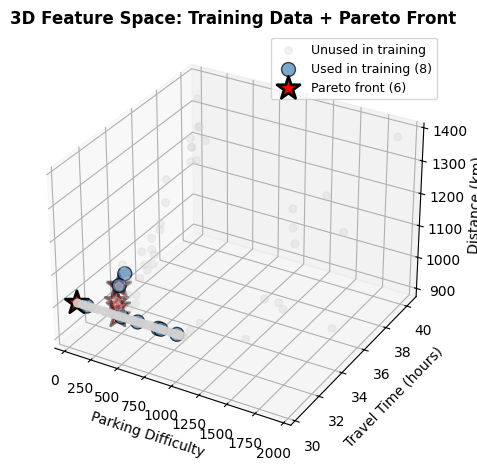

In [10]:
def visualize_training_data(training_data_file, cost_pool_file):
    """
    Create visualizations for training data and save to dedicated folder
    
    Creates folder: {training_data_file_stem}/
    Saves: pareto_visualization.png, usage_analysis.png
    """
    import json
    import numpy as np
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D
    from collections import Counter
    from pathlib import Path
    
    # Use the same folder as training data
    output_dir = Path(training_data_file).parent
    print(f"\n📁 Creating visualizations in: {output_dir}/")
    
    # Load data
    with open(cost_pool_file, 'r') as f:
        cost_pool = json.load(f)
    
    with open(training_data_file, 'r') as f:
        training_data = json.load(f)
    
    print(f"  Cost pool: {len(cost_pool)} solutions")
    print(f"  Training data: {len(training_data)} samples")
    
    # Extract features
    all_parking = [s['features']['avg_parking_difficulty'] for s in cost_pool]
    all_time = [s['features']['total_travel_hours'] for s in cost_pool]
    all_distance = [s['features']['total_distance_km'] for s in cost_pool]
    
    # Get pool_ids used in training
    training_pool_ids = set([s['metadata']['pool_id'] for s in training_data])
    
    # Separate into used/unused
    used_parking = [s['features']['avg_parking_difficulty'] for s in cost_pool if s['pool_id'] in training_pool_ids]
    used_time = [s['features']['total_travel_hours'] for s in cost_pool if s['pool_id'] in training_pool_ids]
    used_distance = [s['features']['total_distance_km'] for s in cost_pool if s['pool_id'] in training_pool_ids]
    
    unused_parking = [s['features']['avg_parking_difficulty'] for s in cost_pool if s['pool_id'] not in training_pool_ids]
    unused_time = [s['features']['total_travel_hours'] for s in cost_pool if s['pool_id'] not in training_pool_ids]
    unused_distance = [s['features']['total_distance_km'] for s in cost_pool if s['pool_id'] not in training_pool_ids]
    
    # Find Pareto front
    class SimpleParetoFinder:
        def dominates(self, a, b):
            better_in_one = False
            for key in ['avg_parking_difficulty', 'total_travel_hours', 'total_distance_km']:
                if a['features'][key] > b['features'][key]:
                    return False
                if a['features'][key] < b['features'][key]:
                    better_in_one = True
            return better_in_one
        
        def find_pareto_front(self, solutions):
            pareto = []
            for candidate in solutions:
                if not any(self.dominates(other, candidate) 
                          for other in solutions 
                          if other['pool_id'] != candidate['pool_id']):
                    pareto.append(candidate)
            return pareto
    
    finder = SimpleParetoFinder()
    pareto_front = finder.find_pareto_front(cost_pool)
    
    pareto_parking = [s['features']['avg_parking_difficulty'] for s in pareto_front]
    pareto_time = [s['features']['total_travel_hours'] for s in pareto_front]
    pareto_distance = [s['features']['total_distance_km'] for s in pareto_front]
    pareto_ids = [s['pool_id'] for s in pareto_front]
    
    print(f"  Pareto front: {len(pareto_front)} solutions")
    print(f"  Used in training: {len(training_pool_ids)} unique solutions")
    
    # =========================================================================
    # VISUALIZATION 1: 3D Scatter Plot + 2D Projections
    # =========================================================================
    
    fig = plt.figure(figsize=(16, 12))
    
    # Plot 1: 3D view
    ax1 = fig.add_subplot(2, 2, 1, projection='3d')
    
    # Unused solutions (gray)
    ax1.scatter(unused_parking, unused_time, unused_distance, 
               c='lightgray', s=30, alpha=0.3, label='Unused in training')
    
    # Used solutions (blue)
    ax1.scatter(used_parking, used_time, used_distance,
               c='steelblue', s=100, alpha=0.7, edgecolors='black', 
               linewidths=1, label=f'Used in training ({len(training_pool_ids)})')
    
    # Pareto front (red stars)
    ax1.scatter(pareto_parking, pareto_time, pareto_distance,
               c='red', s=300, marker='*', edgecolors='black',
               linewidths=2, label=f'Pareto front ({len(pareto_front)})', zorder=10)
    
    ax1.set_xlabel('Parking Difficulty', fontsize=10)
    ax1.set_ylabel('Travel Time (hours)', fontsize=10)
    ax1.set_zlabel('Distance (km)', fontsize=10)
    ax1.set_title('3D Feature Space: Training Data + Pareto Front', fontsize=12, fontweight='bold')
    ax1.legend(fontsize=9)
    

    
    
    for row, col, pos, x_feat, y_feat, title in projections:
        ax = fig.add_subplot(row, col, pos) 
        
        # Extract data for this projection
        unused_x = [s['features'][x_feat] for s in cost_pool if s['pool_id'] not in training_pool_ids]
        unused_y = [s['features'][y_feat] for s in cost_pool if s['pool_id'] not in training_pool_ids]
        
        used_x = [s['features'][x_feat] for s in cost_pool if s['pool_id'] in training_pool_ids]
        used_y = [s['features'][y_feat] for s in cost_pool if s['pool_id'] in training_pool_ids]
        
        pareto_x = [s['features'][x_feat] for s in pareto_front]
        pareto_y = [s['features'][y_feat] for s in pareto_front]
        
        # Plot
        ax.scatter(unused_x, unused_y, c='lightgray', s=30, alpha=0.3, label='Unused')
        ax.scatter(used_x, used_y, c='steelblue', s=100, alpha=0.7, 
                  edgecolors='black', linewidths=1, label='Used')
        ax.scatter(pareto_x, pareto_y, c='red', s=300, marker='*',
                  edgecolors='black', linewidths=2, label='Pareto', zorder=10)
        
        # Add pool_id labels for Pareto points
        for s in pareto_front:
            ax.annotate(f"ID={s['pool_id']}", 
                       (s['features'][x_feat], s['features'][y_feat]),
                       xytext=(5, 5), textcoords='offset points', 
                       fontsize=8, alpha=0.7)
        
        ax.set_xlabel(x_feat.replace('_', ' ').title(), fontsize=10)
        ax.set_ylabel(y_feat.replace('_', ' ').title(), fontsize=10)
        ax.set_title(title, fontsize=11, fontweight='bold')
        ax.legend(fontsize=8)
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    viz1_path = Path(output_dir) / 'pareto_visualization.png'
    plt.savefig(viz1_path, dpi=150, bbox_inches='tight')
    plt.close()
    print(f"  ✓ Saved: {viz1_path}")
    
    # =========================================================================
    # VISUALIZATION 2: Usage Analysis
    # =========================================================================
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Count how many times each solution is used
    pool_id_counts = Counter([s['metadata']['pool_id'] for s in training_data])
    
    # Left plot: Bar chart of usage
    ax = axes[0]
    pool_ids_sorted = sorted(pool_id_counts.keys())
    counts = [pool_id_counts[pid] for pid in pool_ids_sorted]
    colors = ['red' if pid in pareto_ids else 'steelblue' for pid in pool_ids_sorted]
    
    bars = ax.bar(range(len(pool_ids_sorted)), counts, color=colors, 
                 edgecolor='black', alpha=0.7)
    ax.set_xlabel('Pool ID', fontsize=12)
    ax.set_ylabel('Times Used in Training', fontsize=12)
    ax.set_title(f'Solution Usage Distribution\n(Red = Pareto front)', 
                fontsize=12, fontweight='bold')
    ax.set_xticks(range(len(pool_ids_sorted)))
    ax.set_xticklabels([f'{pid}' for pid in pool_ids_sorted], rotation=90, fontsize=8)
    ax.grid(True, alpha=0.3, axis='y')
    
    # Add percentage labels on top
    for i, (bar, count) in enumerate(zip(bars, counts)):
        pct = count / len(training_data) * 100
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(counts)*0.01,
               f'{pct:.1f}%', ha='center', va='bottom', fontsize=8)
    
    # Right plot: Pareto vs Non-Pareto usage
    ax = axes[1]
    
    pareto_usage = sum(pool_id_counts.get(pid, 0) for pid in pareto_ids)
    non_pareto_usage = len(training_data) - pareto_usage
    
    pareto_in_training = len([pid for pid in training_pool_ids if pid in pareto_ids])
    non_pareto_in_training = len(training_pool_ids) - pareto_in_training
    
    labels = [f'Pareto Front\n({pareto_in_training} solutions)', 
              f'Non-Pareto\n({non_pareto_in_training} solutions)']
    sizes = [pareto_usage, non_pareto_usage]
    colors_pie = ['red', 'steelblue']
    
    wedges, texts, autotexts = ax.pie(sizes, labels=labels, colors=colors_pie,
                                       autopct='%1.1f%%', startangle=90,
                                       textprops={'fontsize': 11, 'fontweight': 'bold'})
    ax.set_title('Training Data: Pareto vs Non-Pareto Usage', 
                fontsize=12, fontweight='bold')
    
    plt.tight_layout()
    viz2_path = Path(output_dir) / 'usage_analysis.png'
    plt.savefig(viz2_path, dpi=150, bbox_inches='tight')
    plt.close()
    print(f"  ✓ Saved: {viz2_path}")
    
    # =========================================================================
    # STATISTICS SUMMARY
    # =========================================================================
    
    stats_path = Path(output_dir) / 'statistics.txt'
    with open(stats_path, 'w') as f:
        f.write("="*60 + "\n")
        f.write("TRAINING DATA STATISTICS\n")
        f.write("="*60 + "\n\n")
        
        f.write(f"Cost Pool:\n")
        f.write(f"  Total solutions: {len(cost_pool)}\n")
        f.write(f"  Pareto front: {len(pareto_front)} ({len(pareto_front)/len(cost_pool)*100:.1f}%)\n\n")
        
        f.write(f"Training Data:\n")
        f.write(f"  Total samples: {len(training_data)}\n")
        f.write(f"  Unique solutions: {len(training_pool_ids)}\n")
        f.write(f"  Samples per solution: {len(training_data)/len(training_pool_ids):.1f}\n\n")
        
        f.write(f"Pareto Front Usage:\n")
        f.write(f"  Pareto solutions in training: {pareto_in_training}/{len(pareto_front)}\n")
        f.write(f"  Pareto samples: {pareto_usage}/{len(training_data)} ({pareto_usage/len(training_data)*100:.1f}%)\n\n")
        
        f.write(f"Top 5 most used solutions:\n")
        for pool_id, count in pool_id_counts.most_common(5):
            is_pareto = "⭐ PARETO" if pool_id in pareto_ids else ""
            f.write(f"  pool_id={pool_id}: {count} times ({count/len(training_data)*100:.1f}%) {is_pareto}\n")
        
        f.write("\n" + "="*60 + "\n")
    
    print(f"  ✓ Saved: {stats_path}")
    print(f"\n✅ All visualizations saved to: {output_dir}/\n")

print("✓ visualize_training_data function defined")
visualize_training_data(
    f'training_data_20251030_081113/training_data.json',
    'cost_pool.json'
)

## 9. View Sample

In [11]:
# Show first training sample
if len(collector.training_data) > 0:
    print(json.dumps(collector.training_data[0], indent=2))

{
  "sample_id": 1,
  "preferences": {
    "parking_importance": 0.3375537429491996,
    "time_importance": 0.33720870815163795,
    "distance_importance": 0.32523754889916257
  },
  "costs": {
    "costPerTravelHour": 10.65,
    "costPerKm": 0.0968,
    "parking_multiplier": 0.55
  },
  "features": {
    "total_distance_km": 907.93,
    "total_travel_hours": 32.37,
    "total_cost": 420740.57,
    "num_stops": 208,
    "num_vehicles_used": 8,
    "unplanned_jobs": 2,
    "avg_parking_difficulty": 173.76
  },
  "metadata": {
    "pool_id": 7,
    "rank_for_preference": 1,
    "pareto_distance": 0.21224472688689178,
    "selection_pool_size": 100,
    "timestamp": "2025-11-04T18:03:25.969863"
  },
  "sample_weight": 3.2026161337297534
}


## 10. Using Sample Weights in Model Training

**V7 Update:** Each training sample now includes a `sample_weight` field that indicates how well it matches the preference.

- **Closer matches** (lower distance) get **higher weights** → Model focuses more on these
- **Distant matches** (higher distance) get **lower weights** → Model still learns diversity but with less emphasis

This allows the model to learn from diverse examples while prioritizing better matches.

In [ ]:
# Example: Training a model with sample weights
# This is a demonstration of how to use the sample_weight field

import json
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# Load training data
with open("training_data_20251030_081113/training_data.json", "r") as f:
    data = json.load(f)

# Prepare features (X) and targets (y)
X = np.array([[s['preferences']['parking_importance'],
               s['preferences']['time_importance'],
               s['preferences']['distance_importance']] for s in data])

y = np.array([[s['costs']['costPerTravelHour'],
               s['costs']['costPerKm'],
               s['costs']['parking_multiplier']] for s in data])

# Extract sample weights
sample_weights = np.array([s['sample_weight'] for s in data])

print(f"Dataset: {len(data)} samples")
print(f"Features (preferences): {X.shape}")
print(f"Targets (costs): {y.shape}")
print(f"Sample weights: min={sample_weights.min():.3f}, max={sample_weights.max():.3f}")

# Split data
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(
    X, y, sample_weights, test_size=0.2, random_state=42
)

# Train model WITHOUT sample weights (baseline)
model_baseline = RandomForestRegressor(n_estimators=100, random_state=42)
model_baseline.fit(X_train, y_train)
score_baseline = model_baseline.score(X_test, y_test)

# Train model WITH sample weights (weighted)
model_weighted = RandomForestRegressor(n_estimators=100, random_state=42)
model_weighted.fit(X_train, y_train, sample_weight=w_train)  # ← Key difference!
score_weighted = model_weighted.score(X_test, y_test)

print(f"\nModel Performance (R² score):")
print(f"  Baseline (no weights): {score_baseline:.4f}")
print(f"  Weighted (with weights): {score_weighted:.4f}")
print(f"  Improvement: {(score_weighted - score_baseline):.4f}")

print("\n✓ Sample weights successfully used in training!")
print("  The weighted model focuses more on close matches while still learning from diverse examples.")